In [38]:
from pymongo import MongoClient
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, array_contains, lit, when, count, split
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark import SparkContext
import matplotlib.pyplot as plt

In [2]:
# Connect to MongoDB
client = MongoClient('mongodb://mongodb:27017/')
db = client.Youtube_Database
collection = db.youtube_data_us

# Print the first document
print(collection.find_one())

# Close the connection
client.close()

{'_id': ObjectId('67704d0a369451acbe81243e'), 'video_id': '3C66w5Z0ixs', 'title': 'I ASKED HER TO BE MY GIRLFRIEND...', 'publishedAt': '2020-08-11T19:20:14Z', 'channelId': 'UCvtRTOMP2TqYqu51xNrqAzg', 'channelTitle': 'Brawadis', 'categoryId': 22, 'trending_date': '2020-08-12T00:00:00Z', 'tags': 'brawadis|prank|basketball|skits|ghost|funny videos|vlog|vlogging|NBA|browadis|challenges|bmw i8|faze rug|faze rug brother|mama rug and papa rug', 'view_count': 1514614, 'likes': 156908, 'dislikes': 5855, 'comment_count': 35313, 'thumbnail_link': 'https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg', 'comments_disabled': False, 'ratings_disabled': False, 'description': 'SUBSCRIBE to BRAWADIS ▶ http://bit.ly/SubscribeToBrawadis\r\rFOLLOW ME ON SOCIAL\r▶ Twitter: https://twitter.com/Brawadis\r▶ Instagram: https://www.instagram.com/brawadis/\r▶ Snapchat: brawadis\r\rHi! I’m Brandon Awadis and I like to make dope vlogs, pranks, reactions, challenges and basketball videos. Don’t forget to subscribe and com

## Spark

In [3]:
spark_ = SparkSession.builder \
    .appName("company_database") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/Company_Database") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/Company_Database") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/Youtube_Database") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/Youtube_Database") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

## Importanção dos dados de cada pais

In [4]:
df_us = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_us").load()
df_br = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_br").load()
df_ca = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_ca").load()
df_fr = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_fr").load()
df_gb = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_gb").load()
df_in = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_in").load()
df_kr = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_kr").load()
df_mx = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_mx").load()

## Importanção dos dados de empresa

In [6]:
df_dell = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.dell_data").load()
df_ibm = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.ibm_data").load()
df_intel = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.intel_data").load()
df_microsoft = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.microsoft_data").load()
df_nvidia = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.nvidia_data").load()
df_sony = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.sony_data").load()

## Dicionario das empresas e seus nomes para posteriormente fazer a união dos dfs com a coluna company_name

In [7]:
dict_companies = {'companies': [
                 {'dataframe':df_dell, 'name': 'dell'},
                 {'dataframe':df_ibm, 'name': 'ibm'},
                 {'dataframe':df_intel, 'name': 'intel'},
                 {'dataframe':df_microsoft, 'name': 'microsoft'},
                 {'dataframe':df_nvidia, 'name': 'nvidia'},
                 {'dataframe':df_sony, 'name': 'sony'},  
                ]
            }

In [8]:
for company in dict_companies['companies']:
    company["dataframe"] = company["dataframe"].withColumn("company", lit(company["name"]))

In [46]:
df_companies = dict_companies['companies'][0]['dataframe'].union(dict_companies['companies'][1]['dataframe']).union(dict_companies['companies'][2]['dataframe']).union(dict_companies['companies'][3]['dataframe']).union(dict_companies['companies'][4]['dataframe']).union(dict_companies['companies'][5]['dataframe'])

In [27]:
# Filtrar os videos por país relacionados a uma empresa

companies = ['nvidia', 'dell', 'ibm', 'intel', 'microsoft', 'sony']
countries_df = [df_us, df_br, df_ca, df_fr, df_gb, df_in, df_kr, df_mx]
countries = ['us', 'br', 'ca', 'fr', 'gb', 'in', 'kr', 'mx']

yt = {company: {} for company in companies}

def filter_df(df, company):
    filtered_df = df.filter(
        (col('description').contains(company)) |
        (col('title').contains(company)) |
        (col('tags').contains(company)) |
        (col('channelTitle').contains(company))
    )
    return filtered_df.withColumn("company", lit(company))

for company in companies:
    for country, country_df in zip(countries, countries_df):
        filtered_data = filter_df(country_df, company)
        yt[company].setdefault(country, []).append(filtered_data)

## União dos df de cada pais num só

In [28]:
from functools import reduce

# Extract all DataFrames from the yt dictionary
all_dfs = [
    df 
    for company, country_data in yt.items() 
    for country, dfs in country_data.items() 
    for df in dfs
]

# Union all DataFrames using reduce
if all_dfs:
    df_yt = reduce(lambda df1, df2: df1.union(df2), all_dfs)
else:
    df_yt = None  # Handle case where there are no DataFrames

# Result: `df_yt` is the union of all DataFrames

In [37]:
df_yt.count()

39352

## Colunas existentes

In [39]:
df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



In [10]:
df_all_companies.count()

57226

## Quantidade de videos relacionados a x empresa

## União dos videos de cada empresa

In [ ]:
df_yt_companies = df_us.union(filtered_df_nvidia).union(filtered_df_ibm).union(filtered_df_dell).union(filtered_df_intel).union(filtered_df_microsoft).union(filtered_df_sony)

df_yt_companies - todos os videos das empresas a serem estudadas<br> 
df_all_companies - dados de todas as empreas a serem estudadas

## Estudo dos nulos

In [42]:
# YT
df_yt.select([count(when(col(c).isNull(), c)).alias(c) for c in df_yt.columns]).show()

+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+
|_id|categoryId|channelId|channelTitle|comment_count|comments_disabled|description|dislikes|likes|publishedAt|ratings_disabled|tags|thumbnail_link|title|trending_date|video_id|view_count|company|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+
|  0|         0|        0|           0|            0|                0|          0|       0|    0|          0|               0|   0|             0|    0|            0|       0|         0|      0|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+



In [ ]:
duplicates = df_yt.groupBy(df_yt.columns).count().filter("count > 1")
duplicates.show()

## Plots

In [47]:
df_companies.columns

['Adj Close',
 'Close',
 'Date',
 'High',
 'Low',
 'Open',
 'Volume',
 '_id',
 'company_name']

In [49]:
df_yt.columns

['_id',
 'categoryId',
 'channelId',
 'channelTitle',
 'comment_count',
 'comments_disabled',
 'description',
 'dislikes',
 'likes',
 'publishedAt',
 'ratings_disabled',
 'tags',
 'thumbnail_link',
 'title',
 'trending_date',
 'video_id',
 'view_count',
 'company']

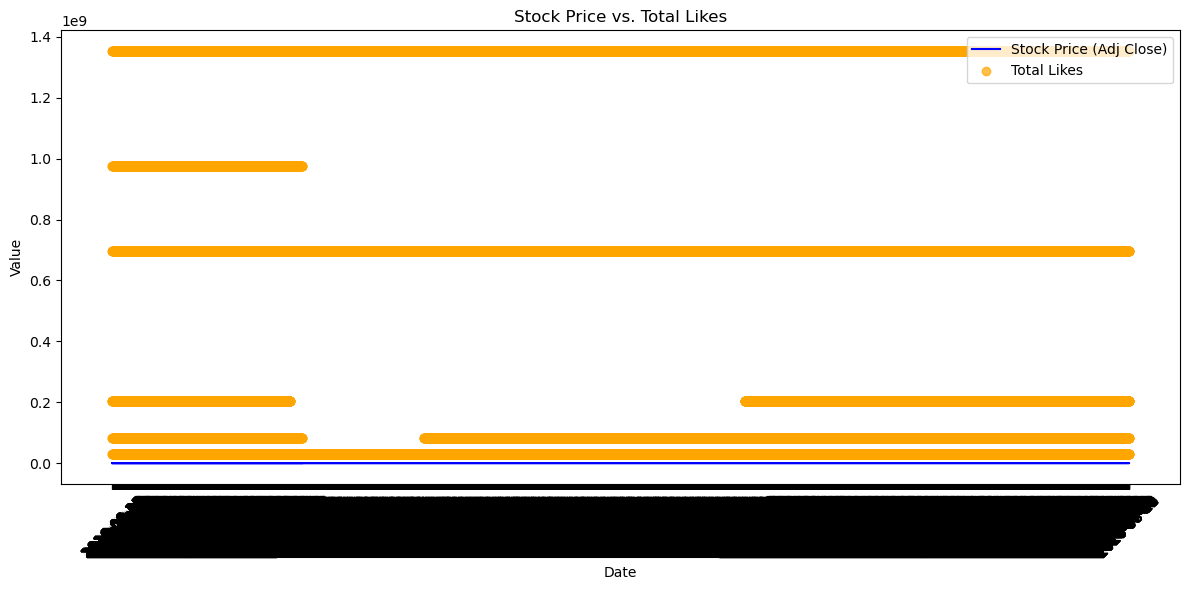

In [51]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum as spark_sum

# Aggregate video engagement metrics
df_yt_agg = df_yt.groupBy("company").agg(
    spark_sum("likes").alias("total_likes"),
    spark_sum("view_count").alias("total_views")
)

# Join aggregated engagement metrics with stock data
df_combined = df_companies.join(
    df_yt_agg,
    df_companies["company_name"] == df_yt_agg["company"],
    how="inner"
).select("Date", "Adj Close", "company_name", "total_likes", "total_views")

# Collect data for plotting
plot_data = df_combined.toPandas()

# Plot Stock Price vs. Total Likes
plt.figure(figsize=(12, 6))
plt.plot(plot_data["Date"], plot_data["Adj Close"], label="Stock Price (Adj Close)", color="blue")
plt.scatter(plot_data["Date"], plot_data["total_likes"], label="Total Likes", color="orange", alpha=0.7)
plt.title("Stock Price vs. Total Likes")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
